In [5]:
#this may take up to 30 seconds the first time is run
import micropip
await micropip.install('lmfit')
await micropip.install('xlrd')

import scipy
import matplotlib.pyplot as plt
import lmfit
import io
import numpy as np
import pandas as pd

# Read rheology data

In [10]:
Data_file=pd.ExcelFile('Flow_curve_example.xls')
Data_file.sheet_names

['Details', 'Flow sweep - 1', 'Flow sweep - 2']

In [18]:
data=Data_file.parse('Flow sweep - 2',skiprows=[0,2])
data.head()

,Shear rate,Stress,Viscosity,Step time,Temperature,Normal stress
0,100.0000,0.785576,0.007856,7.035,24.994,-25.8372
1,79.4336,0.667926,0.008409,14.122,25.001,-25.5272
2,63.0956,0.570374,0.009040,21.198,24.996,-26.0631
3,50.1186,0.488046,0.009738,28.277,24.992,-25.5495
4,39.8109,0.418776,0.010519,35.368,25.000,-25.1221


# define model : Three component model

$$\sigma=\sigma_y+\sigma_y\cdot(\dot\gamma/\dot\gamma_c)^{0.5}+\eta_{bg}\cdot\dot\gamma$$

In [19]:
def TC(x, ystress=1.0, eta_bg=0.1, gammadot_crit=0.1):
    """Three component model
    Note:
    .. math::
       \sigma=\sigma_y+\sigma_y\cdot(\dot\gamma/\dot\gamma_c)^{0.5}+\eta_{bg}\cdot\dot\gamma
    Args:
        ystress: yield stress [Pa]
        eta_bg : Background viscosity [Pa s]
        gammadot_crit : Critical shear rate [1/s]
    Returns:
        stress : Shear Stress, [Pa]
    """
    return ystress + ystress * (x / gammadot_crit) ** 0.5 + eta_bg * x

TC_model = lmfit.Model(TC, prefix="TC_")

# set parameters for model class
TC_model.set_param_hint("ystress", min=0)
TC_model.set_param_hint("eta_bg", min=0, vary=True)
TC_model.set_param_hint("gammadot_crit", min=0)

In [20]:
res_fit=TC_model.fit(data['Stress'],x=data['Shear rate'], weights=1/data['Stress'])

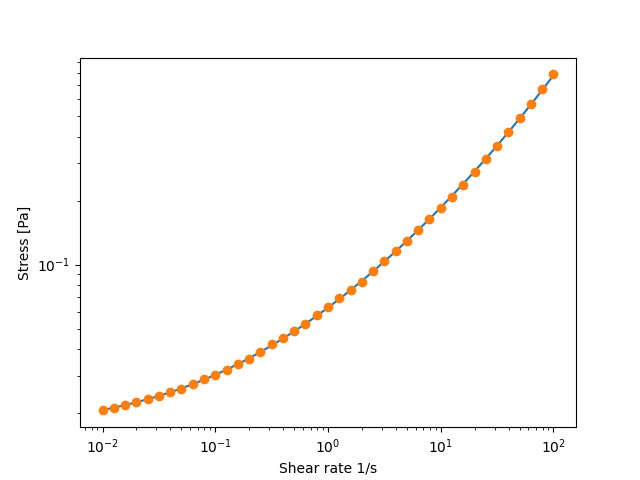

In [25]:
plt.plot(data['Shear rate'],res_fit.best_fit)
plt.plot(data['Shear rate'], data['Stress'], 'o')
plt.xlabel('Shear rate 1/s')
plt.ylabel('Stress [Pa]')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [23]:
def plot_fit_res(fit_res, show_par_values=False,exp_err=0.05):
    
    fig, (ax1,ax3) = plt.subplots(2,1, sharex=True)
    ax2 = ax1.twinx()
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_yscale('log')
        
    ax1.plot(fit_res.userkws['x'],fit_res.data,'o', color='red', mfc='none', label='data')
    ax1.plot(fit_res.userkws['x'],fit_res.eval(x=fit_res.userkws['x']),'-', color='black', label='best fit')

    ax2.plot(fit_res.userkws['x'],fit_res.data/fit_res.userkws['x'],'o', color='blue', mfc='none')
    ax2.plot(fit_res.userkws['x'],fit_res.eval(x=fit_res.userkws['x'])/fit_res.userkws['x'],'-', color='black')
    
    ax3.plot(fit_res.userkws['x'], (fit_res.data-fit_res.eval(x=fit_res.userkws['x']))/fit_res.data,'o', color='blue', mfc='none')
    ax3.fill_between(fit_res.userkws['x'], -exp_err,exp_err,
                     color='blue',alpha=0.2,label='estimated exp error')

    
    
    ax1.set_ylabel('$\sigma [Pa]$')
    ax3.set_xlabel('$\dot\gamma [1/s]$')
    ax2.set_ylabel('$\eta [Pa s]$')
    ax3.set_ylabel('relative residuals')
    
    #ax3.set_ylim(-0.2,0.2)
    
    ax3.legend()
    
    if show_par_values:
        mod_par_text=''
        for item in fit_res.params:
            mod_par_text+=(f'{item} : {fit_res.params[item].value:.2E} \n')

        mod_par_text+=f'Red chi square: {fit_res.redchi:.2E} \n'

        plt.text(-1, 0.95, mod_par_text, transform=plt.gca().transAxes, fontsize=14,verticalalignment='top')
        fig.suptitle(fit_res.model)
    
    return fig

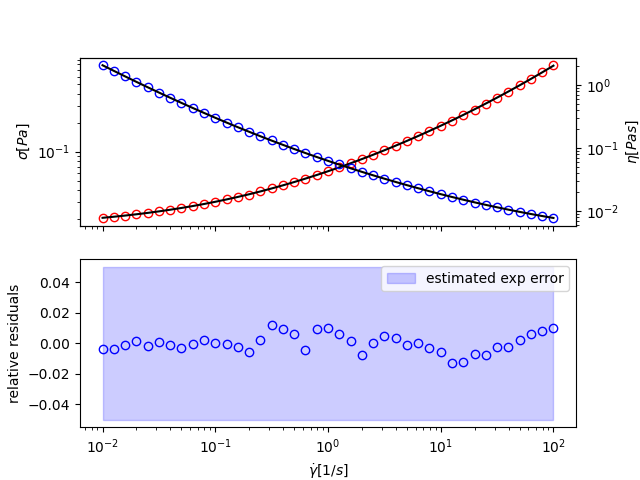

In [10]:
fig=plot_fit_res(res_fit)
plt.show()